# Hierarchical Models

In [1]:
import collections
import itertools

from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymc3 as pm
import pandas as pd

%matplotlib inline
sns.set_style('darkgrid')

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Same utility functions from last chapter

I know, I know... (DRY it!)

In [2]:
def acf(trace, lag):
    '''
    Autocorrelation function, based on Pearson correlation
    coefficient.
    '''
    correlation, _ = stats.stats.pearsonr(trace[:-lag], trace[lag:])
    return correlation


def ess(trace):
    '''
    Effective sample size, as defined in Kruschke's "Doing
    Bayesian Data Analysis", 2nd edition, p. 184.
    '''
    significant_autocorrelations = []
    for lag in itertools.count(start=1):
        autocorrelation = acf(trace, lag)
        significant_autocorrelations.append(autocorrelation)
        if autocorrelation < 0.05:
            break
    N = len(trace)
    denominator = 1 + 2 * sum(significant_autocorrelations)
    return N / denominator

# Exercise 1

Therapoetic touch data with different priors

### Question A + B

Compare vague gamma distributed priors with different parameters.

In [3]:
# Calculations are based on info from wikipedia
# http://en.wikipedia.org/wiki/Gamma_distribution

GammaParams = collections.namedtuple('GammaParams', ['shape', 'scale'])


def gamma_params_from_mean_and_sd(mean, sd):
    return GammaParams((mean / sd) ** 2, sd ** 2 / mean)


def gamma_params_from_mode_and_sd(mode, sd):
    scale = ((mode ** 2 + 4 * sd ** 2) ** 0.5 - mode) / 2
    shape = (sd / scale) ** 2
    return GammaParams(shape, scale)


def plot_gammas(*gamma_params_list, extra_labels=(), max_x=200):
    x = np.linspace(0, max_x, 200)
    for gamma_params, extra_label in itertools.zip_longest(gamma_params_list, extra_labels):
        text = r'$k = {:.2f}$; $\theta = {:.2f}$'.format(gamma_params.shape, gamma_params.scale)
        if extra_label:
            text = '{}: {}'.format(extra_label, text)
        plt.plot(x, stats.gamma(gamma_params.shape, scale=gamma_params.scale).pdf(x), label=text)

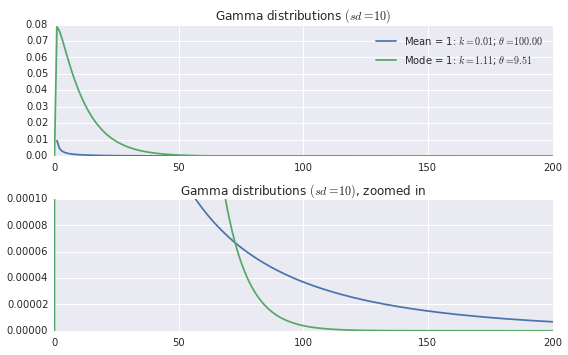

In [4]:
plt.figure(figsize=(8, 5))
plt.subplot(2, 1, 1)
gammas = (gamma_params_from_mean_and_sd(1, 10), gamma_params_from_mode_and_sd(1, 10))
plot_gammas(*gammas, extra_labels=('Mean = 1', 'Mode = 1'))
title = 'Gamma distributions $(sd = 10)$'
plt.legend()
plt.title(title)

plt.subplot(2, 1, 2)
plot_gammas(*gammas)
plt.ylim((0, .0001))
plt.title(title + ', zoomed in')
plt.tight_layout()

The gamma distribution with mode = 1 favors values between 0.1 and 75.

The gamma distribution with mean = 1 favors very small values or those larger than 75.

### Question C

Notice how the different priors above cause similar posteriors.

In [5]:
TRACE_LENGTH = 10000

data = pd.read_csv('TherapeuticTouchData.csv')
subjects_data = [data[data.s == subject].y.values for subject in data.s.unique()]

In [6]:
def run_model_with_gamma_params(gamma_params, subjects=None, data=None):
    
    assert subjects or data, 'Supply at least one of [subjects, data]'
    if data:
        subjects = len(data)
    
    with pm.Model():
        
        # Priors
        omega = pm.Beta('omega', 1, 1)
        # PyMC3 works with rate parameter instead of scale parameter
        kappa = pm.Gamma('kappa', gamma_params.shape, 1 / gamma_params.scale) + 2

        # Model hierarchies
        beta_a = omega * (kappa - 2) + 1
        beta_b = (1 - omega) * (kappa - 2) + 1
        subject_theta = pm.Beta('theta', beta_a, beta_b, shape=(subjects, 1))
        if data:
            pm.Bernoulli('y', subject_theta, observed=data)

        # Inference
        start = pm.find_MAP()
        # Metropolis sample the prior faster
        sampler = pm.NUTS(scaling=start) if data else pm.Metropolis()
        trace = pm.sample(TRACE_LENGTH, sampler, start=start)

    return trace

In [7]:
gamma_params = gamma_params_from_mean_and_sd(1, 10)
mean_1_trace = run_model_with_gamma_params(gamma_params, data=subjects_data)

 [-----------------100%-----------------] 10000 of 10000 complete in 205.3 sec

/usr/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  return f(*args, **kwds)


In [8]:
gamma_params = gamma_params_from_mode_and_sd(1, 10)
mode_1_trace = run_model_with_gamma_params(gamma_params, data=subjects_data)

 [-----------------100%-----------------] 10000 of 10000 complete in 88.9 sec

In [9]:
mean_1_omega = mean_1_trace.get_values('omega')
mode_1_omega = mode_1_trace.get_values('omega')

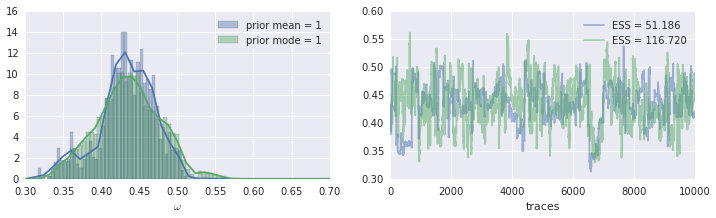

In [10]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
sns.distplot(mean_1_omega, label='prior mean = 1')
sns.distplot(mode_1_omega, label='prior mode = 1')
plt.xlim((0.3, 0.7))
plt.xlabel(r'$\omega$')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(mean_1_omega, label='ESS = {:.3f}'.format(ess(mean_1_omega)), alpha=.5)
plt.plot(mode_1_omega, label='ESS = {:.3f}'.format(ess(mode_1_omega)), alpha=.5)
plt.xlabel('traces')
_ = plt.legend()

Notice that the low ESS are due to omega being a high level variable. Comparing to subject's theta:

In [11]:
subject_theta = [x.item(6) for x in mean_1_trace.get_values('theta')]
print(ess(subject_theta))

10106.4049597


### Question D

There is a minor difference in the posterior due to the change in the prior, although it is much less significant than expected.

Question: "For which prior does the nargubak oisterior distribution on k have a bigger large-value tail?"

Didn't find a big difference in the large-value tail, as the author suggest.

Question: "When k is larger, what effect does that have on shrinkage of the thetas values?"

In [12]:
def plot_shrinkage_comparison(traces):
    '''
    traces is a list of (trace, label, color) tuples.
    '''
    plt.figure(figsize=(6, 2))
    for i, (trace, label, color) in enumerate(traces):
        thetas = trace.get_values('theta')
        ones = np.ones(thetas.shape[1])
        means = thetas.reshape(thetas.shape[:-1]).mean(axis=0)
        plt.bar(means, height=((-1) ** i) * ones, width=0.005, alpha=.3, linewidth=0,
                color=color, label=label)
    plt.xlim((.3, .6))
    plt.yticks((), ())
    plt.legend()
    plt.xlabel(r'$\theta$')

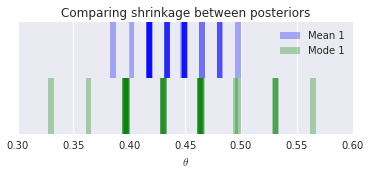

In [13]:
plot_shrinkage_comparison(((mean_1_trace, 'Mean 1', 'blue'), (mode_1_trace, 'Mode 1', 'green')))
_ = plt.title('Comparing shrinkage between posteriors')

It is obvious from omega histogram that mode == 1 presents a broader distribution. The above strengthen this observation with the exact shrinkage of the thetas, presenting much more shrinkage when the mean is 1.

# Exercise 2

Examine the same priors again, using MCMC to gain insights about the prior shrinkage.

In [14]:
TRACE_LENGTH = 100000
gamma_params = gamma_params_from_mean_and_sd(1, 10)
mean_1_prior = run_model_with_gamma_params(gamma_params, subjects=28)

 [-----------------100%-----------------] 100000 of 100000 complete in 93.9 sec

In [15]:
gamma_params = gamma_params_from_mode_and_sd(1, 10)
mode_1_prior = run_model_with_gamma_params(gamma_params, subjects=28)

 [-----------------100%-----------------] 100000 of 100000 complete in 92.8 sec

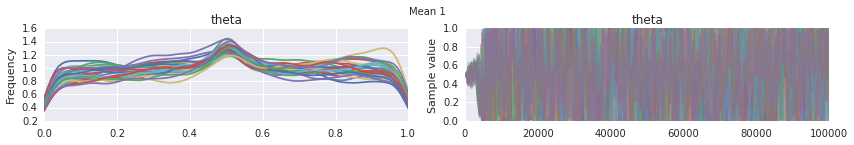

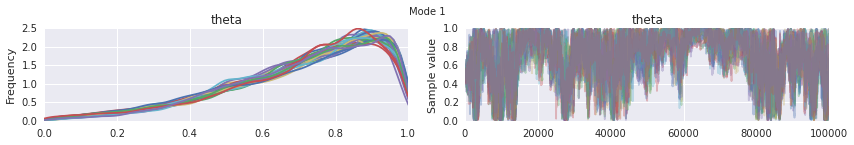

In [16]:
fig = pm.traceplot(mean_1_prior, vars=['theta'])
fig.suptitle('Mean 1')
fig = pm.traceplot(mode_1_prior, vars=['theta'])
_ = fig.suptitle('Mode 1')

### Question A + B

The mode 1 prior result in much rounded thetas because kappa is concentrated around low values (compared to mean 1 prior), hence the thetas are less broad.

If the priors should be vague as possible mean 1 prior is probably better.